# Statistical comparisons of the transcriptomic and proteomic expression of *Ruegeria pomeroyi* DSS-3 and *Alteromonas macleodii* MIT1002 under regimes of diauxic growth on defined substrates

### Updated: 20230913

In [3]:
#packages needed for analysis and visualization
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Dataframes for compiling transcriptomic coverage data along with gene calls

#Getting transcriptomic gene coverages and annotations for Alteromonas macleodii MIT1002
#Put the data into pandas dataframes
MIT1002_gene_cov_df = pd.read_csv('./data/MIT1002-Genome-gene_coverages.txt',sep='\t') #the data is in tab-delimited text format, so the separator is set as a tab aka '\t'
MIT1002_gene_call_df = pd.read_csv('./data/MIT1002-Genome-gene_calls.txt',sep='\t')

#Ruegeria pomeroyi DSS-3 has a genome and a megaplasmid, so we need to get the data for both and then combine them
DSS3_gene_cov_df = pd.read_csv('./data/DSS3-Chromosome-gene_coverages.txt',sep='\t')
DSS3_mp_gene_cov_df = pd.read_csv('./data/DSS3-Megaplasmid-gene_coverages.txt',sep='\t')
DSS3_gene_cov_df = pd.concat([DSS3_gene_cov_df,DSS3_mp_gene_cov_df]) #adds chromosomal and megaplasmid gene coverages into one df

DSS3_gene_call_df = pd.read_csv('./data/DSS3-Chromosome-gene_calls.txt',sep='\t')
DSS3_mp_gene_call_df = pd.read_csv('./data/DSS3-Megaplasmid-gene_calls.txt',sep='\t')
DSS3_gene_call_df = pd.concat([DSS3_gene_call_df,DSS3_mp_gene_call_df]) #adds chromosomal and megaplasmid gene calls/annotations into one df

In [6]:
#Dictionary of OD600 measurements of each expt to use for biomass corrections
#Each of these entries lists the OD600 for a sample at the time it was taken to account for differences in biomass
OD_dict = {
'DSS3_glc_a':0.276,'DSS3_glc_b':0.272,'DSS3_glc_c':0.291,
'DSS3_ac_a':0.033,'DSS3_ac_b':0.057,
'DSS3_glc_ac_19_a':0.023,'DSS3_glc_ac_19_b':0.02,'DSS3_glc_ac_19_c':0.031,
'DSS3_glc_ac_34_a':0.171,'DSS3_glc_ac_34_b':0.171,'DSS3_glc_ac_34_c':0.186,
'MIT1002_glc_a':0.485,'MIT1002_glc_b':0.465,'MIT1002_glc_c':0.469,
'MIT1002_ac_a':0.035,'MIT1002_ac_b':0.044,'MIT1002_ac_c':0.038,
'MIT1002_glc_ac_5_a':0.041,'MIT1002_glc_ac_5_c':0.048,
'MIT1002_glc_ac_8_a':0.18,'MIT1002_glc_ac_8_b':0.199,'MIT1002_glc_ac_8_c':0.213
}

#We included mRNA standards (MTST-5 and MTST-6) with extraction for absolute quantitation
#Need to correct coverage values based on Satinsky et al. 2013
#Corrected read count to number of molecules based on two standards added at beginning of extraction
#values calculated from mapping counts of standards based on actual amount of mRNA molecules added
Sa_Ss_corr_dict = {'DSS3_glc_a':78161, 'DSS3_glc_b':64935, 'DSS3_glc_c':83914, 'DSS3_ac_b':8117, 
                   'DSS3_glc_ac_19_a':12390, 'DSS3_glc_ac_19_b':11781, 'DSS3_glc_ac_19_c':10622,
                   'DSS3_glc_ac_34_a':48406, 'DSS3_glc_ac_34_b':51065, 'DSS3_glc_ac_34_c':42251,
                   'MIT1002_ac_b':143499, 'MIT1002_ac_c':121273,
                   'MIT1002_glc_a':207034, 'MIT1002_glc_ac_5_a':60048, 'MIT1002_glc_ac_5_c':47345,
                   'MIT1002_glc_ac_8_a':114737, 'MIT1002_glc_ac_8_b':110192, 'MIT1002_glc_ac_8_c':75095,
                   'MIT1002_glc_b':338420, 'MIT1002_glc_c':212932}

#DSS3 corrections
#This block goes over each sample, adds a new column that is corrected 'corr' and fills that new column with the gene coverage times the standard correction (Sa/Ss) and divides that value by the OD600
#These corrections give us the absolute number of mRNA molecules per OD600 for each sample
DSS3_gene_cov_df['DSS3_glc_a_corr'] = DSS3_gene_cov_df['DSS3_glc_a'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_a'])/OD_dict['DSS3_glc_a'])
DSS3_gene_cov_df['DSS3_glc_b_corr'] = DSS3_gene_cov_df['DSS3_glc_b'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_b'])/OD_dict['DSS3_glc_b'])
DSS3_gene_cov_df['DSS3_glc_c_corr'] = DSS3_gene_cov_df['DSS3_glc_c'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_c'])/OD_dict['DSS3_glc_c'])
DSS3_gene_cov_df['DSS3_ac_a_est_corr'] = DSS3_gene_cov_df['DSS3_ac_a'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_ac_b'])/OD_dict['DSS3_ac_b'])
DSS3_gene_cov_df['DSS3_ac_b_corr'] = DSS3_gene_cov_df['DSS3_ac_b'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_ac_b'])/OD_dict['DSS3_ac_b'])
DSS3_gene_cov_df['DSS3_glc_ac_19_a_corr'] = DSS3_gene_cov_df['DSS3_glc_ac_19_a'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_ac_19_a'])/OD_dict['DSS3_glc_ac_19_a'])
DSS3_gene_cov_df['DSS3_glc_ac_19_b_corr'] = DSS3_gene_cov_df['DSS3_glc_ac_19_b'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_ac_19_b'])/OD_dict['DSS3_glc_ac_19_b'])
DSS3_gene_cov_df['DSS3_glc_ac_19_c_corr'] = DSS3_gene_cov_df['DSS3_glc_ac_19_c'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_ac_19_c'])/OD_dict['DSS3_glc_ac_19_c'])
DSS3_gene_cov_df['DSS3_glc_ac_34_a_corr'] = DSS3_gene_cov_df['DSS3_glc_ac_34_a'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_ac_34_a'])/OD_dict['DSS3_glc_ac_34_a'])
DSS3_gene_cov_df['DSS3_glc_ac_34_b_corr'] = DSS3_gene_cov_df['DSS3_glc_ac_34_b'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_ac_34_b'])/OD_dict['DSS3_glc_ac_34_b'])
DSS3_gene_cov_df['DSS3_glc_ac_34_c_corr'] = DSS3_gene_cov_df['DSS3_glc_ac_34_c'].apply(lambda x: (x*Sa_Ss_corr_dict['DSS3_glc_ac_34_c'])/OD_dict['DSS3_glc_ac_34_c'])


#change the read counts for each sample to relative % of total reads
DSS3_cols = ['DSS3_ac_a_est_corr', 'DSS3_ac_b_corr', 'DSS3_glc_a_corr','DSS3_glc_ac_19_a_corr', 'DSS3_glc_ac_19_b_corr', 'DSS3_glc_ac_19_c_corr',
        'DSS3_glc_ac_34_a_corr', 'DSS3_glc_ac_34_b_corr', 'DSS3_glc_ac_34_c_corr','DSS3_glc_b_corr', 'DSS3_glc_c_corr'] #list of columns to relativize

#this step is optional and can be commented out (#) to get the absolute data
#relativizing the counts (as a percent of total counts for that sample) negates the standard correction, but provides useful data for comparing samples while ignoring biomass and growth phase related differences
DSS3_gene_cov_df[DSS3_cols] = DSS3_gene_cov_df[DSS3_cols].div(DSS3_gene_cov_df[DSS3_cols].sum(axis=0), axis=1).multiply(100) 

#MIT1002 corrections
#This repeats the same corrections as above for MIT1002
MIT1002_gene_cov_df['MIT1002_glc_a_corr'] = MIT1002_gene_cov_df['MIT1002_glc_a'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_a'])/OD_dict['MIT1002_glc_a'])
MIT1002_gene_cov_df['MIT1002_glc_b_corr'] = MIT1002_gene_cov_df['MIT1002_glc_b'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_b'])/OD_dict['MIT1002_glc_b'])
MIT1002_gene_cov_df['MIT1002_glc_c_corr'] = MIT1002_gene_cov_df['MIT1002_glc_c'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_c'])/OD_dict['MIT1002_glc_c'])
MIT1002_gene_cov_df['MIT1002_ac_a_est_corr'] = MIT1002_gene_cov_df['MIT1002_ac_a'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_ac_c'])/OD_dict['MIT1002_ac_c'])
MIT1002_gene_cov_df['MIT1002_ac_b_corr'] = MIT1002_gene_cov_df['MIT1002_ac_b'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_ac_b'])/OD_dict['MIT1002_ac_b'])
MIT1002_gene_cov_df['MIT1002_ac_c_corr'] = MIT1002_gene_cov_df['MIT1002_ac_c'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_ac_c'])/OD_dict['MIT1002_ac_c'])
MIT1002_gene_cov_df['MIT1002_glc_ac_5_a_corr'] = MIT1002_gene_cov_df['MIT1002_glc_ac_5_a'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_ac_5_a'])/OD_dict['MIT1002_glc_ac_5_a'])
MIT1002_gene_cov_df['MIT1002_glc_ac_5_c_corr'] = MIT1002_gene_cov_df['MIT1002_glc_ac_5_c'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_ac_5_c'])/OD_dict['MIT1002_glc_ac_5_c'])
MIT1002_gene_cov_df['MIT1002_glc_ac_8_a_corr'] = MIT1002_gene_cov_df['MIT1002_glc_ac_8_a'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_ac_8_a'])/OD_dict['MIT1002_glc_ac_8_a'])
MIT1002_gene_cov_df['MIT1002_glc_ac_8_b_corr'] = MIT1002_gene_cov_df['MIT1002_glc_ac_8_b'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_ac_8_b'])/OD_dict['MIT1002_glc_ac_8_b'])
MIT1002_gene_cov_df['MIT1002_glc_ac_8_c_corr'] = MIT1002_gene_cov_df['MIT1002_glc_ac_8_c'].apply(lambda x: (x*Sa_Ss_corr_dict['MIT1002_glc_ac_8_c'])/OD_dict['MIT1002_glc_ac_8_c'])

#change the read counts for each sample to relative % of total reads
MIT1002_cols = ['MIT1002_ac_a_est_corr', 'MIT1002_ac_b_corr', 'MIT1002_ac_c_corr',
        'MIT1002_glc_a_corr', 'MIT1002_glc_ac_5_a_corr', 'MIT1002_glc_ac_5_c_corr',
        'MIT1002_glc_ac_8_a_corr', 'MIT1002_glc_ac_8_b_corr', 'MIT1002_glc_ac_8_c_corr',
        'MIT1002_glc_b_corr', 'MIT1002_glc_c_corr']

#this step is optional and can be commented out (#) to get the absolute data
#relativizing the counts (as a percent of total counts for that sample) negates the standard correction, but provides useful data for comparing samples while ignoring biomass and growth phase related differences
MIT1002_gene_cov_df[MIT1002_cols] = MIT1002_gene_cov_df[MIT1002_cols].div(MIT1002_gene_cov_df[MIT1002_cols].sum(axis=0), axis=1).multiply(100)

In [8]:
#Now bring in the proteome abundance data

#DSS3 NSAF calculated and normalized data; applying matching gene_ids with gene calls above
DSS3_prot_abund_df = pd.read_csv('./data/DSS3_norm_prot_abund.txt',sep='\t')
DSS3_accession_gcid_match_df = DSS3_gene_call_df[['gene_callers_id','SPO_ID (ACCESSION)']]
DSS3_accession_gcid_match_df = DSS3_accession_gcid_match_df.rename({'SPO_ID (ACCESSION)':'Accession'},axis=1)
DSS3_prot_abund_df = DSS3_accession_gcid_match_df.merge(DSS3_prot_abund_df, on='Accession',how='inner')

#MIT1002 NSAF calculated and normalized data; applying matching gene_ids with gene calls above
MIT1002_prot_abund_df = pd.read_csv('./data/MIT1002_norm_prot_abund.txt',sep='\t')
#This file matches the accession to the gene_callers_id to the accession used for proteomics
MIT1002_accession_gcid_match_df = pd.read_csv('./data/MIT1002_gcid_acc_dict.txt',sep='\t') #this adds GenBank accession numbers for each gene to assist with matching genes with gene calls
MIT1002_prot_abund_df = MIT1002_accession_gcid_match_df.merge(MIT1002_prot_abund_df, on='Accession',how='inner')

In [9]:
#The proteomics and transcriptomics data are in separate dfs, but they share sample names. The following section adds '_prot' and '_rna' to help tell data apart downstream
#let's adjust names so we can tell diff between prot and rna
prot_name_dict = {'DSS3_ac_a':'DSS3_ac_a_prot','DSS3_ac_b':'DSS3_ac_b_prot','DSS3_ac_c':'DSS3_ac_c_prot',
                  'DSS3_glc_ac_19_a':'DSS3_glc_ac_19_a_prot', 'DSS3_glc_ac_19_b':'DSS3_glc_ac_19_b_prot', 'DSS3_glc_ac_19_c':'DSS3_glc_ac_19_c_prot',
                  'DSS3_glc_ac_34_a':'DSS3_glc_ac_34_a_prot', 'DSS3_glc_ac_34_b':'DSS3_glc_ac_34_b_prot', 'DSS3_glc_ac_34_c':'DSS3_glc_ac_34_c_prot',
                  'DSS3_glc_a':'DSS3_glc_a_prot', 'DSS3_glc_b':'DSS3_glc_b_prot', 'DSS3_glc_c':'DSS3_glc_c_prot',
                  'MIT1002_glc_a':'MIT1002_glc_a_prot','MIT1002_glc_b':'MIT1002_glc_b_prot', 'MIT1002_glc_c':'MIT1002_glc_c_prot',
                  'MIT1002_glc_ac_5_a':'MIT1002_glc_ac_5_a_prot','MIT1002_glc_ac_5_b':'MIT1002_glc_ac_5_b_prot', 'MIT1002_glc_ac_5_c':'MIT1002_glc_ac_5_c_prot',
                  'MIT1002_glc_ac_8_a':'MIT1002_glc_ac_8_a_prot', 'MIT1002_glc_ac_8_b':'MIT1002_glc_ac_8_b_prot', 'MIT1002_glc_ac_8_c':'MIT1002_glc_ac_8_c_prot',
                  'MIT1002_ac_a':'MIT1002_ac_a_prot','MIT1002_ac_b':'MIT1002_ac_b_prot', 'MIT1002_ac_c':'MIT1002_ac_c_prot'
                   }
DSS3_prot_abund_df.rename(prot_name_dict,axis=1,inplace=True)
MIT1002_prot_abund_df.rename(prot_name_dict,axis=1,inplace=True)

rna_name_dict = {'DSS3_ac_a_est_corr':'DSS3_ac_a_rna', 'DSS3_ac_b_corr':'DSS3_ac_b_rna',
                 'DSS3_glc_ac_19_a_corr':'DSS3_glc_ac_19_a_rna', 'DSS3_glc_ac_19_b_corr':'DSS3_glc_ac_19_b_rna', 'DSS3_glc_ac_19_c_corr':'DSS3_glc_ac_19_c_rna',
                 'DSS3_glc_ac_34_a_corr':'DSS3_glc_ac_34_a_rna', 'DSS3_glc_ac_34_b_corr':'DSS3_glc_ac_34_b_rna', 'DSS3_glc_ac_34_c_corr':'DSS3_glc_ac_34_c_rna',
                 'DSS3_glc_a_corr':'DSS3_glc_a_rna', 'DSS3_glc_b_corr':'DSS3_glc_b_rna', 'DSS3_glc_c_corr':'DSS3_glc_c_rna', 
                 'MIT1002_glc_a_corr':'MIT1002_glc_a_rna','MIT1002_glc_b_corr':'MIT1002_glc_b_rna', 'MIT1002_glc_c_corr':'MIT1002_glc_c_rna',
                 'MIT1002_glc_ac_5_a_corr':'MIT1002_glc_ac_5_a_rna', 'MIT1002_glc_ac_5_c_corr':'MIT1002_glc_ac_5_c_rna',
                 'MIT1002_glc_ac_8_a_corr':'MIT1002_glc_ac_8_a_rna', 'MIT1002_glc_ac_8_b_corr':'MIT1002_glc_ac_8_b_rna', 'MIT1002_glc_ac_8_c_corr':'MIT1002_glc_ac_8_c_rna',
                 'MIT1002_ac_a_est_corr':'MIT1002_ac_a_rna','MIT1002_ac_b_corr':'MIT1002_ac_b_rna', 'MIT1002_ac_c_corr':'MIT1002_ac_c_rna'
                 }
DSS3_gene_cov_df.rename(rna_name_dict,axis=1,inplace=True)
MIT1002_gene_cov_df.rename(rna_name_dict,axis=1,inplace=True)

#Make some lists of names to make it easy to subset data
DSS3_rna_name_list = ['gene_callers_id'] + list(rna_name_dict.values())[0:11]
DSS3_prot_name_list = ['gene_callers_id'] + list(prot_name_dict.values())[0:12]
MIT1002_rna_name_list = ['gene_callers_id'] + list(rna_name_dict.values())[11:]
MIT1002_prot_name_list = ['gene_callers_id'] + list(prot_name_dict.values())[12:]

#For this study, we're going to focus on the corrected data, so I'll subset down to the data renamed above
DSS3_gene_cov_df_rel = DSS3_gene_cov_df[DSS3_rna_name_list]
DSS3_prot_abund_df_rel = DSS3_prot_abund_df[DSS3_prot_name_list]
MIT1002_gene_cov_df_rel = MIT1002_gene_cov_df[MIT1002_rna_name_list]
MIT1002_prot_abund_df_rel = MIT1002_prot_abund_df[MIT1002_prot_name_list]

#expt names for mapping replicates for downstream stats and plotting
expt_dict = {
    'DSS3_glc_ac_19_c_rna':'DSS3_early',
 'DSS3_glc_a_rna':'DSS3_glc',
 'DSS3_glc_ac_19_b_rna':'DSS3_early',
 'DSS3_glc_a_prot':'DSS3_glc',
 'DSS3_glc_b_rna':'DSS3_glc',
 'DSS3_ac_a_rna':'DSS3_ac',
 'DSS3_glc_c_prot':'DSS3_glc',
 'DSS3_glc_ac_34_a_rna':'DSS3_late',
 'DSS3_glc_c_rna':'DSS3_glc',
 'DSS3_ac_b_rna':'DSS3_ac',
 'DSS3_glc_ac_19_b_prot':'DSS3_early',
 'DSS3_glc_ac_19_c_prot':'DSS3_early',
 'DSS3_glc_ac_34_c_rna':'DSS3_late',
 'DSS3_ac_a_prot':'DSS3_ac',
 'DSS3_glc_ac_34_a_prot':'DSS3_late',
 'DSS3_glc_ac_34_b_prot':'DSS3_late',
 'DSS3_ac_b_prot':'DSS3_ac',
 'DSS3_glc_b_prot':'DSS3_glc',
 'DSS3_glc_ac_19_a_rna':'DSS3_early',
 'DSS3_glc_ac_19_a_prot':'DSS3_early',
 'DSS3_glc_ac_34_c_prot':'DSS3_late',
 'DSS3_ac_c_prot':'DSS3_ac',
 'DSS3_glc_ac_34_b_rna':'DSS3_late',
    'MIT1002_glc_b_rna':'MIT1002_glc',
 'MIT1002_ac_b_rna':'MIT1002_ac',
 'MIT1002_glc_b_prot':'MIT1002_glc',
 'MIT1002_glc_ac_5_a_prot':'MIT1002_early',
 'MIT1002_glc_ac_5_c_prot':'MIT1002_early',
 'MIT1002_glc_ac_5_a_rna':'MIT1002_early',
 'MIT1002_glc_ac_8_c_rna':'MIT1002_late',
 'MIT1002_glc_c_rna':'MIT1002_glc',
 'MIT1002_ac_c_rna':'MIT1002_ac',
 'MIT1002_glc_ac_8_c_prot':'MIT1002_late',
 'MIT1002_glc_a_rna':'MIT1002_glc',
 'MIT1002_glc_ac_5_c_rna':'MIT1002_early',
 'MIT1002_glc_ac_8_a_prot':'MIT1002_late',
 'MIT1002_ac_c_prot':'MIT1002_ac',
 'MIT1002_glc_c_prot':'MIT1002_glc',
 'MIT1002_glc_ac_5_b_prot':'MIT1002_early',
 'MIT1002_ac_a_rna':'MIT1002_ac',
 'MIT1002_glc_a_prot':'MIT1002_glc',
 'MIT1002_glc_ac_8_a_rna':'MIT1002_late',
 'MIT1002_glc_ac_8_b_prot':'MIT1002_late',
 'MIT1002_glc_ac_8_b_rna':'MIT1002_late',
 'MIT1002_ac_a_prot':'MIT1002_ac',
 'MIT1002_ac_b_prot':'MIT1002_ac'
}

#This lets us maps both prot and rna back to just the sample replicate name
#I know all of this renaming and unnaming seems circuitous, but it all serves a purpose!
#And a dictionary takes no time to call, so this isn't hurting anything
rep_dict = {
    'DSS3_glc_ac_19_c_rna':'DSS3_early_c',
 'DSS3_glc_a_rna':'DSS3_glc_a',
 'DSS3_glc_ac_19_b_rna':'DSS3_early_b',
 'DSS3_glc_a_prot':'DSS3_glc_a',
 'DSS3_glc_b_rna':'DSS3_glc_b',
 'DSS3_ac_a_rna':'DSS3_ac_a',
 'DSS3_glc_c_prot':'DSS3_glc_c',
 'DSS3_glc_ac_34_a_rna':'DSS3_late_a',
 'DSS3_glc_c_rna':'DSS3_glc_c',
 'DSS3_ac_b_rna':'DSS3_ac_b',
 'DSS3_glc_ac_19_b_prot':'DSS3_early_b',
 'DSS3_glc_ac_19_c_prot':'DSS3_early_c',
 'DSS3_glc_ac_34_c_rna':'DSS3_late_c',
 'DSS3_ac_a_prot':'DSS3_ac_a',
 'DSS3_glc_ac_34_a_prot':'DSS3_late_a',
 'DSS3_glc_ac_34_b_prot':'DSS3_late_b',
 'DSS3_ac_b_prot':'DSS3_ac_b',
 'DSS3_glc_b_prot':'DSS3_glc_b',
 'DSS3_glc_ac_19_a_rna':'DSS3_early_a',
 'DSS3_glc_ac_19_a_prot':'DSS3_early_a',
 'DSS3_glc_ac_34_c_prot':'DSS3_late_c',
 'DSS3_ac_c_prot':'DSS3_ac_c',
 'DSS3_glc_ac_34_b_rna':'DSS3_late_b',
    'MIT1002_glc_b_rna':'MIT1002_glc_b',
 'MIT1002_ac_b_rna':'MIT1002_ac_b',
 'MIT1002_glc_b_prot':'MIT1002_glc_b',
 'MIT1002_glc_ac_5_a_prot':'MIT1002_early_a',
 'MIT1002_glc_ac_5_c_prot':'MIT1002_early_c',
 'MIT1002_glc_ac_5_a_rna':'MIT1002_early_a',
 'MIT1002_glc_ac_8_c_rna':'MIT1002_late_c',
 'MIT1002_glc_c_rna':'MIT1002_glc_c',
 'MIT1002_ac_c_rna':'MIT1002_ac_c',
 'MIT1002_glc_ac_8_c_prot':'MIT1002_late_c',
 'MIT1002_glc_a_rna':'MIT1002_glc_a',
 'MIT1002_glc_ac_5_c_rna':'MIT1002_early_c',
 'MIT1002_glc_ac_8_a_prot':'MIT1002_late_a',
 'MIT1002_ac_c_prot':'MIT1002_ac_c',
 'MIT1002_glc_c_prot':'MIT1002_glc_c',
 'MIT1002_glc_ac_5_b_prot':'MIT1002_early_b',
 'MIT1002_ac_a_rna':'MIT1002_ac_a',
 'MIT1002_glc_a_prot':'MIT1002_glc_a',
 'MIT1002_glc_ac_8_a_rna':'MIT1002_late_a',
 'MIT1002_glc_ac_8_b_prot':'MIT1002_late_b',
 'MIT1002_glc_ac_8_b_rna':'MIT1002_late_b',
 'MIT1002_ac_a_prot':'MIT1002_ac_a',
 'MIT1002_ac_b_prot':'MIT1002_ac_b'
}

#I use the original names below in further modified dfs, so I need to make a copy here 
DSS3_rna_abund_df1 = DSS3_gene_cov_df_rel
DSS3_prot_abund_df1 = DSS3_prot_abund_df_rel
MIT1002_rna_abund_df1 = MIT1002_gene_cov_df_rel
MIT1002_prot_abund_df1 = MIT1002_prot_abund_df_rel

#Now I need to melt the data to be able to combine replicates into one sample name
DSS3_rna_abund_melt = DSS3_rna_abund_df1.melt(id_vars='gene_callers_id')
DSS3_prot_abund_melt = DSS3_prot_abund_df1.melt(id_vars='gene_callers_id')
MIT1002_rna_abund_melt = MIT1002_rna_abund_df1.melt(id_vars='gene_callers_id')
MIT1002_prot_abund_melt = MIT1002_prot_abund_df1.melt(id_vars='gene_callers_id')

#Now apply the renaming dictionaries to add columns for the "experiment" and for which "replicate" each sample is
DSS3_rna_abund_melt['expt'] = DSS3_rna_abund_melt['variable'].map(expt_dict)
DSS3_prot_abund_melt['expt'] = DSS3_prot_abund_melt['variable'].map(expt_dict)
MIT1002_rna_abund_melt['expt'] = MIT1002_rna_abund_melt['variable'].map(expt_dict)
MIT1002_prot_abund_melt['expt'] = MIT1002_prot_abund_melt['variable'].map(expt_dict)

DSS3_rna_abund_melt['rep'] = DSS3_rna_abund_melt['variable'].map(rep_dict)
DSS3_prot_abund_melt['rep'] = DSS3_prot_abund_melt['variable'].map(rep_dict)
MIT1002_rna_abund_melt['rep'] = MIT1002_rna_abund_melt['variable'].map(rep_dict)
MIT1002_prot_abund_melt['rep'] = MIT1002_prot_abund_melt['variable'].map(rep_dict)


#Now I need to merge the RNA and prot data
DSS3_abund_df = DSS3_rna_abund_melt.merge(DSS3_prot_abund_melt,on=['gene_callers_id','rep','expt'],how='right')
MIT1002_abund_df = MIT1002_rna_abund_melt.merge(MIT1002_prot_abund_melt,on=['gene_callers_id','rep','expt'],how='right')

#Now, I'm going to add a column of log transformed data for fold change calculation
DSS3_abund_df['log2_value_x'] = DSS3_abund_df['value_x'].apply(lambda x: np.log2(x))
MIT1002_abund_df['log2_value_x'] = MIT1002_abund_df['value_x'].apply(lambda x: np.log2(x))
DSS3_abund_df['log2_value_y'] = DSS3_abund_df['value_y'].apply(lambda x: np.log2(x))
MIT1002_abund_df['log2_value_y'] = MIT1002_abund_df['value_y'].apply(lambda x: np.log2(x))

In [10]:
#This pairwise fold-change calculator filters data based on statistical significance
#returns a df including FC, stats (ANOVA, BH validity, and Tukey adjusted p-values)
#input needs to include a df with corrected and log2 normalized data (i.e. DSS3_abund_df or MIT1002_abund_df)
#"rna" or "prot" needs to be specified for data type
#strain needs to be specified for name matching
#takes all expts and does pairwise comparisons for the four expts
def pairwise_fold_change_calculator(df,data_type=None,strain=None):
    #These lists store pairwise differences for each gene in each sample
    AB_diff_list = []
    AC_diff_list = []
    AD_diff_list = []
    BC_diff_list = []
    BD_diff_list = []
    CD_diff_list = []
    #This list stores ANOVA p-values for each gene
    p_val_list = []
    #These lists help keep track of which gene is being analyzed
    gene_numbers = []
    gene_ids = []
    #Keep the average abunance (corrected) for each gene in each sample
    A_average_abund_list = []
    B_average_abund_list = []
    C_average_abund_list = []
    D_average_abund_list = []
    #Create a list of genes and details to use to guide iteration
    gene_list = set(df['gene_callers_id'].to_list()) #gene ids
    expt_list = list(set(df['expt'].to_list())) #expt names
    #Sample names
    A_name = f'{strain}_ac' 
    B_name = f'{strain}_glc'
    C_name = f'{strain}_late'
    D_name = f'{strain}_early'
    #Create separate dfs for each experiment, subsetting the input df
    dfA = df[df['expt'] == A_name]
    dfB = df[df['expt'] == B_name]
    dfC = df[df['expt'] == C_name]
    dfD = df[df['expt'] == D_name]
    
    #Parse the input options to determine which data (prot or rna) to use from the df
    if data_type == 'rna':
        log2_value = 'log2_value_x' #set the different data names based on type. The x is RNA and y is prot because of the melting process.
        value = 'value_x'
    elif data_type == 'prot':
        log2_value = 'log2_value_y'
        value = 'value_y'
    else:
        raise ValueError('Need to specify "rna" or "prot".') #Kick back an error if data isn't specified
    
    #Now we're starting the loopiness
    #First we'll iterate over each gene in our gene list from above
    for gene in gene_list:
        #get log-normalized values for fold-change calculation
        A_vals = dfA[dfA['gene_callers_id'] == gene][log2_value].dropna() #get the A values for this expt
        B_vals = dfB[dfB['gene_callers_id'] == gene][log2_value].dropna() #get the B values for this expt
        C_vals = dfC[dfC['gene_callers_id'] == gene][log2_value].dropna() #get the C values for this expt
        D_vals = dfD[dfD['gene_callers_id'] == gene][log2_value].dropna() #get the D values for this expt
        
        #Mean log2 normalized abundance for each sample
        A_average = np.average(A_vals)
        B_average = np.average(B_vals)
        C_average = np.average(C_vals)
        D_average = np.average(D_vals)
        
        #get non-log2 transformed abundance values for the ANOVA
        A_abunds = dfA[dfA['gene_callers_id'] == gene][value].dropna() #get the A values for this expt
        B_abunds = dfB[dfB['gene_callers_id'] == gene][value].dropna() #get the B values for this expt
        C_abunds = dfC[dfC['gene_callers_id'] == gene][value].dropna() #get the C values for this expt
        D_abunds = dfD[dfD['gene_callers_id'] == gene][value].dropna() #get the D values for this expt
        
        #Mean abundance calculations
        A_average_abund = np.average(A_abunds)
        B_average_abund = np.average(B_abunds)
        C_average_abund = np.average(C_abunds)
        D_average_abund = np.average(D_abunds)
        
        #Adding the mean abundances to our list in the top level for output at the end for each gene
        A_average_abund_list.append(A_average_abund)
        B_average_abund_list.append(B_average_abund)
        C_average_abund_list.append(C_average_abund)
        D_average_abund_list.append(D_average_abund)
        
        #start with a one-way anova to compare the mean abundance (non-log) data
        F,p = f_oneway(A_vals,B_vals,C_vals,D_vals,axis=0)

        #note: This anova is run for every single gene. This is thousands of times.
        #Because of this extreme multiple testing, we will have to apply a multiple testing correction to really understand the significance of each value

        #Calculate the log2-fold change  (log(A/B) == log(A) - log(B))
        AB_diff = A_average - B_average
        AC_diff = A_average - C_average
        AD_diff = A_average - D_average
        BC_diff = B_average - C_average
        BD_diff = B_average - D_average
        CD_diff = C_average - D_average
        
        #Here the differences are the log2-FC values. We will add those to the list at the top to keep track for each gene
        AB_diff_list.append(AB_diff)
        AC_diff_list.append(AC_diff)
        AD_diff_list.append(AD_diff)
        BC_diff_list.append(BC_diff)
        BD_diff_list.append(BD_diff)
        CD_diff_list.append(CD_diff)
        
        #Keep track above of which gene we analyzed and its anova p value (we have the F stat for each gene but it isn't kept at this time)
        gene_numbers.append(gene)
        p_val_list.append(p)

        #This loop is now repeated for each gene. Data are stored in lists above. Python lists maintain order, so we can stitch the lists together later to get all of our data into a df
    
    #This dictionary sets the title of each column of the results_df using f strings to make custom names so we can keep track of what data and which strain we're analyzing
    #The dictionary also contains each of the above lists with all of the data
    #it's easier to make a df from a dictionary than a bunch of lists
    results_dict = {'gene_callers_id' : gene_numbers, f'{A_name}_mean_abund':A_average_abund_list,f'{B_name}_mean_abund':B_average_abund_list,
                    f'{C_name}_mean_abund':C_average_abund_list,f'{D_name}_mean_abund':D_average_abund_list,
                    f'{A_name}_v_{B_name}_FOLD_CHANGE_{data_type}' : AB_diff_list, f'{A_name}_v_{C_name}_FOLD_CHANGE_{data_type}' : AC_diff_list, 
                    f'{A_name}_v_{D_name}_FOLD_CHANGE_{data_type}' : AD_diff_list, f'{B_name}_v_{C_name}_FOLD_CHANGE_{data_type}' : BC_diff_list, 
                    f'{B_name}_v_{D_name}_FOLD_CHANGE_{data_type}' : BD_diff_list, f'{C_name}_v_{D_name}_FOLD_CHANGE_{data_type}' : CD_diff_list,
                    'ANOVA p-value': p_val_list} 
    
    #convert the above dictionary into a df (column naming is redundant but better safe than sorry)
    results_df = pd.DataFrame(results_dict,columns=['gene_callers_id',f'{A_name}_mean_abund',f'{B_name}_mean_abund',f'{C_name}_mean_abund',f'{D_name}_mean_abund',
                                                    f'{A_name}_v_{B_name}_FOLD_CHANGE_{data_type}', f'{A_name}_v_{C_name}_FOLD_CHANGE_{data_type}',
                                                    f'{A_name}_v_{D_name}_FOLD_CHANGE_{data_type}', f'{B_name}_v_{C_name}_FOLD_CHANGE_{data_type}',
                                                    f'{B_name}_v_{D_name}_FOLD_CHANGE_{data_type}', f'{C_name}_v_{D_name}_FOLD_CHANGE_{data_type}',
                                                    'ANOVA p-value']) #make the df listing the SPO and the differences
    
    #Benjamini Hochberg procedure:
    #Assign rank to each p-value
    results_df = results_df.sort_values(by='ANOVA p-value',ascending=True) #order the df based on p-value
    results_df = results_df.reset_index() #clear the old index which is now out of order
    results_df = results_df.drop(labels='index',axis=1) #drop the old index which was popped into a column
    results_df = results_df.reset_index() #pull the new index into a column titled "index"; this is kind of a cheat to get an ordered list of integers in a new column
    results_df = results_df.rename(columns={"index":"Rank"}) #Use our new ordered list as our Rank
    results_df['Rank'] = results_df['Rank'].apply(lambda x: x +1) #Python starts at 0, but BH procedure starts at 1
    
    #variables for the BH procedure
    m = len(results_df['ANOVA p-value']) #total number of tests
    Q = 0.05 #certainty cutoff
    
    #apply the BH procedure to determine if an ANOVA based p-value is actually significant
    results_df['BH_crit'] = results_df['Rank'].apply(lambda i: (i/m) * Q) #Create the BH critical value
    results_df['BH_valid'] = np.where((results_df['ANOVA p-value'] < results_df['BH_crit']),True,False) #Boolean determination of whether the BH procedure accepts the data

    
    #Apply Tukey HSD (pairwise) for significant genes from BH procedure
    
    #RETURN p-values for each pair. Also, give each pair a name.
    
    res_gene_list = results_df['gene_callers_id'].to_list() #get list of genes to iterate over from results df, just to be safe
    #list of p values for each pair of samples
    ABp_list = [] 
    ACp_list = []
    ADp_list = []
    BCp_list = []
    BDp_list = []
    CDp_list = []

    #This loop is a little tricky because the tukeyhsd gives nothing back if one sample has no data for a gene, but we need to make sure the data all comes out at the same length for reporting
    gene_counter = 0 #Keep count of how many genes we've done so far (how long each list should be)
    for gene in res_gene_list:
        gene_counter +=1 #add to the count as we go
        gene_df = df[df['gene_callers_id'] == gene].dropna() #drop any gene that is all nans, get a df with all data for one gene
        BH_validity = bool(results_df[results_df['gene_callers_id'] == gene]['BH_valid'].to_list()[-1]) #get the True or False for whether a gene passes the BH procedure
        if BH_validity == True: #only test the significant differences from the BH procedure to save time
            if len(set(gene_df['expt'])) >= 2: #Need at least two experiments to compare
                tukey_results = pairwise_tukeyhsd(gene_df[value],gene_df['expt'],alpha=0.05) #run the tukey test comparing the corrected abundance values for each sample
                for result in tukey_results._results_table.data[1:]: #Parse the output to get the data we want; results table has a line for each pairwise comparison
                    if result[-1] == True: #Make sure tukey test reports significance
                        #This grabs the results for each pair and adds them to the appropriate list
                        if (result[0] == A_name) & (result[1] == B_name): 
                            AB_p = result[3]
                            ABp_list.append(AB_p)
                        elif (result[0] == A_name) & (result[1] == C_name):
                            AC_p = result[3]
                            ACp_list.append(AC_p)
                        elif (result[0] == A_name) & (result[1] == D_name):
                            AD_p = result[3]
                            ADp_list.append(AD_p)
                        elif (result[0] == B_name) & (result[1] == C_name):
                            BC_p = result[3]
                            BCp_list.append(BC_p)
                        elif (result[0] == B_name) & (result[1] == D_name):
                            BD_p = result[3]
                            BDp_list.append(BD_p)
                        elif (result[0] == C_name) & (result[1] == D_name):
                            CD_p = result[3]
                            CDp_list.append(CD_p)
                #These checks are to see if we got a result from the above Tukey HSD or not and to fill in nan where we did not to keep the list length the same        
                if len(ABp_list) < gene_counter:
                    ABp_list.append(np.nan)
                if len(ACp_list) < gene_counter:
                    ACp_list.append(np.nan)
                if len(ADp_list) < gene_counter:
                    ADp_list.append(np.nan)
                if len(BCp_list) < gene_counter:
                    BCp_list.append(np.nan)
                if len(BDp_list) < gene_counter:
                    BDp_list.append(np.nan)
                if len(CDp_list) < gene_counter:
                    CDp_list.append(np.nan)
            #This adds nan where only one expt had data for a gene
            else:
                ABp_list.append(np.nan)
                ACp_list.append(np.nan)
                ADp_list.append(np.nan)
                BCp_list.append(np.nan)
                BDp_list.append(np.nan)
                CDp_list.append(np.nan)
        #this adds nan if a gene didn't pass the BH procedure
        elif BH_validity == False:
            ABp_list.append(np.nan)
            ACp_list.append(np.nan)
            ADp_list.append(np.nan)
            BCp_list.append(np.nan)
            BDp_list.append(np.nan)
            CDp_list.append(np.nan)
    
    #This adds each pairwise Tukey HSD adjusted p-value to the results df so we can see the significance of the difference between each sample
    results_df[f'{A_name}_v_{B_name}_Tukey_HSD_adjusted_p'] = np.array(ABp_list)
    results_df[f'{A_name}_v_{C_name}_Tukey_HSD_adjusted_p'] = np.array(ACp_list)
    results_df[f'{A_name}_v_{D_name}_Tukey_HSD_adjusted_p'] = np.array(ADp_list)
    results_df[f'{B_name}_v_{C_name}_Tukey_HSD_adjusted_p'] = np.array(BCp_list)
    results_df[f'{B_name}_v_{D_name}_Tukey_HSD_adjusted_p'] = np.array(BDp_list)
    results_df[f'{C_name}_v_{D_name}_Tukey_HSD_adjusted_p'] = np.array(CDp_list)
    
    #Success, we did statistics! Let's get the data.
    return results_df

In [11]:
#WARNING
#These dfs will take ~26 minutes to generate
#Runtime warnings and ANOVA oneway warnings are normal. Biology is wild.
DSS3_rna_stats_df = pairwise_fold_change_calculator(DSS3_abund_df,data_type='rna',strain='DSS3')
DSS3_prot_stats_df = pairwise_fold_change_calculator(DSS3_abund_df,data_type='prot',strain='DSS3')
MIT1002_rna_stats_df = pairwise_fold_change_calculator(MIT1002_abund_df,data_type='rna',strain='MIT1002')
MIT1002_prot_stats_df = pairwise_fold_change_calculator(MIT1002_abund_df,data_type='prot',strain='MIT1002')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3629: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater t

In [16]:
#Check to make sure it works
DSS3_rna_stats_df

,Rank,gene_callers_id,DSS3_ac_mean_abund,DSS3_glc_mean_abund,DSS3_late_mean_abund,DSS3_early_mean_abund,DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna,DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna,...,DSS3_late_v_DSS3_early_FOLD_CHANGE_rna,ANOVA p-value,BH_crit,BH_valid,DSS3_ac_v_DSS3_glc_Tukey_HSD_adjusted_p,DSS3_ac_v_DSS3_late_Tukey_HSD_adjusted_p,DSS3_ac_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_glc_v_DSS3_late_Tukey_HSD_adjusted_p,DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p
0,1,370,0.355326,0.010746,0.008742,0.187370,5.047809,5.345034,0.922353,0.297226,...,-4.422681,4.472835e-12,0.000018,True,0.0,0.0,0.0000,NaN,NaN,NaN
1,2,3780,0.067258,0.003105,0.003516,0.003365,4.436896,4.258451,4.322648,-0.178445,...,0.064197,4.260000e-11,0.000036,True,0.0,0.0,0.0000,NaN,NaN,NaN
2,3,368,0.071601,0.003375,0.002749,0.037882,4.409182,4.703722,0.918856,0.294541,...,-3.784866,4.685498e-11,0.000054,True,0.0,0.0,0.0000,NaN,NaN,NaN
3,4,1811,0.016678,0.001441,0.001735,0.010531,3.532539,3.265504,0.662819,-0.267036,...,-2.602685,1.540638e-10,0.000072,True,NaN,0.0,0.0001,NaN,NaN,NaN
4,5,854,0.002930,0.052062,0.042863,0.030612,-4.152921,-3.872313,-3.385123,0.280608,...,0.487190,2.410399e-10,0.000090,True,NaN,NaN,NaN,0.0009,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,2784,3295,0.002077,0.002055,0.002107,0.002020,0.010620,-0.022086,0.040252,-0.032705,...,0.062337,9.388024e-01,0.049928,False,NaN,NaN,NaN,NaN,NaN,NaN
2784,2785,1665,0.040543,0.039794,0.038928,0.038554,0.024609,0.066833,0.084243,0.042225,...,0.017409,9.481103e-01,0.049946,False,NaN,NaN,NaN,NaN,NaN,NaN
2785,2786,4255,0.004589,0.004374,0.004532,0.004488,0.058552,0.006313,0.021260,-0.052239,...,0.014947,9.547799e-01,0.049964,False,NaN,NaN,NaN,NaN,NaN,NaN
2786,2787,1479,0.005247,0.005091,0.005149,0.005138,0.044644,0.025552,0.027654,-0.019093,...,0.002103,9.775407e-01,0.049982,False,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Add some annotations to the data to help with interpretation. Specifically KEGG and COG (also SPO ID for DSS-3)
DSS3_rna_stats_genes_df = DSS3_rna_stats_df.merge(DSS3_gene_call_df[['gene_callers_id','SPO_ID (ACCESSION)','KOfam (ACCESSION)','KEGG_Module','COG20_FUNCTION']],on='gene_callers_id',how='left')
DSS3_rna_stats_genes_df['KEGG_Module'] = DSS3_rna_stats_genes_df['KEGG_Module'].apply(lambda x: str(x).split('!!!')[0])

DSS3_prot_stats_genes_df = DSS3_prot_stats_df.merge(DSS3_gene_call_df[['gene_callers_id','SPO_ID (ACCESSION)','KOfam (ACCESSION)','KEGG_Module','COG20_FUNCTION']],on='gene_callers_id',how='left')
DSS3_prot_stats_genes_df['KEGG_Module'] = DSS3_prot_stats_genes_df['KEGG_Module'].apply(lambda x: str(x).split('!!!')[0])

MIT1002_rna_stats_genes_df = MIT1002_rna_stats_df.merge(MIT1002_gene_call_df[['gene_callers_id','KOfam (ACCESSION)','KEGG_Module','COG20_FUNCTION']],on='gene_callers_id',how='left')
MIT1002_rna_stats_genes_df['KEGG_Module'] = MIT1002_rna_stats_genes_df['KEGG_Module'].apply(lambda x: str(x).split('!!!')[0])

MIT1002_prot_stats_genes_df = MIT1002_prot_stats_df.merge(MIT1002_gene_call_df[['gene_callers_id','KOfam (ACCESSION)','KEGG_Module','COG20_FUNCTION']],on='gene_callers_id',how='left')
MIT1002_prot_stats_genes_df['KEGG_Module'] = MIT1002_prot_stats_genes_df['KEGG_Module'].apply(lambda x: str(x).split('!!!')[0])

In [24]:
#Optional (uncomment if desired)
#save the data to tab-delimited txt files for easy use and access
#DSS3_rna_stats_genes_df.to_csv('./DSS3_rna_stats.txt',sep='\t')
#DSS3_prot_stats_genes_df.to_csv('./DSS3_prot_stats.txt',sep='\t')
#MIT1002_rna_stats_genes_df.to_csv('./MIT1002_rna_stats.txt',sep='\t')
#MIT1002_prot_stats_genes_df.to_csv('./MIT1002_prot_stats.txt',sep='\t')

In [19]:
#Subset the stats df to get only the significantly differentially expressed genes by BH procedure
sig_DSS3_rna_stats_genes_df = DSS3_rna_stats_genes_df[DSS3_rna_stats_genes_df['BH_valid'] == True]

#Reshape it just with FC data for heatmapping
heat_sig_DSS3_rna_stats_genes_df = sig_DSS3_rna_stats_genes_df[['KEGG_Module','DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna', 'DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna', 'DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna', 
                                                                'DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna', 'DSS3_glc_v_DSS3_early_FOLD_CHANGE_rna', 'DSS3_late_v_DSS3_early_FOLD_CHANGE_rna']] #subset of FC data
heat_sig_DSS3_rna_stats_genes_df = heat_sig_DSS3_rna_stats_genes_df.set_index('KEGG_Module') #KM as index labels the heatmap
heat_sig_DSS3_rna_stats_genes_df = heat_sig_DSS3_rna_stats_genes_df.sort_index() #Make it alphabetical
heat_sig_DSS3_rna_stats_genes_df = heat_sig_DSS3_rna_stats_genes_df[heat_sig_DSS3_rna_stats_genes_df.index != 'nan'] #Get rid of the nans

In [23]:
#Example check looking at Entner-Doudoroff pathway stats
sig_DSS3_rna_stats_genes_df[sig_DSS3_rna_stats_genes_df['KEGG_Module'].str.contains('Entner',na=False,case=False)]

,Rank,gene_callers_id,DSS3_ac_mean_abund,DSS3_glc_mean_abund,DSS3_late_mean_abund,DSS3_early_mean_abund,DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna,DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna,...,DSS3_ac_v_DSS3_glc_Tukey_HSD_adjusted_p,DSS3_ac_v_DSS3_late_Tukey_HSD_adjusted_p,DSS3_ac_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_glc_v_DSS3_late_Tukey_HSD_adjusted_p,DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p,SPO_ID (ACCESSION),KOfam (ACCESSION),KEGG_Module,COG20_FUNCTION
67,68,3029,0.018886,0.071684,0.066480,0.039666,-1.925132,-1.817154,-1.071047,0.107978,...,0.0,0.0,0.0002,NaN,NaN,NaN,SPO3032,K01690,"Entner-Doudoroff pathway, glucose-6P => glycer...",Dihydroxyacid dehydratase/phosphogluconate deh...
79,80,3028,0.016502,0.051800,0.046922,0.034981,-1.649789,-1.507866,-1.083060,0.141923,...,0.0,0.0,0.0001,NaN,NaN,NaN,SPO3031,K01625,"Entner-Doudoroff pathway, glucose-6P => glycer...",2-keto-3-deoxy-6-phosphogluconate aldolase (Ed...
1460,1461,2417,0.001674,0.000961,0.001950,0.000971,0.805671,-0.220862,0.805950,-1.026533,...,NaN,NaN,NaN,NaN,NaN,NaN,SPO2420,K00874,"Semi-phosphorylative Entner-Doudoroff pathway,...","Sugar or nucleoside kinase, ribokinase family ..."


<AxesSubplot:ylabel='KEGG_Module'>

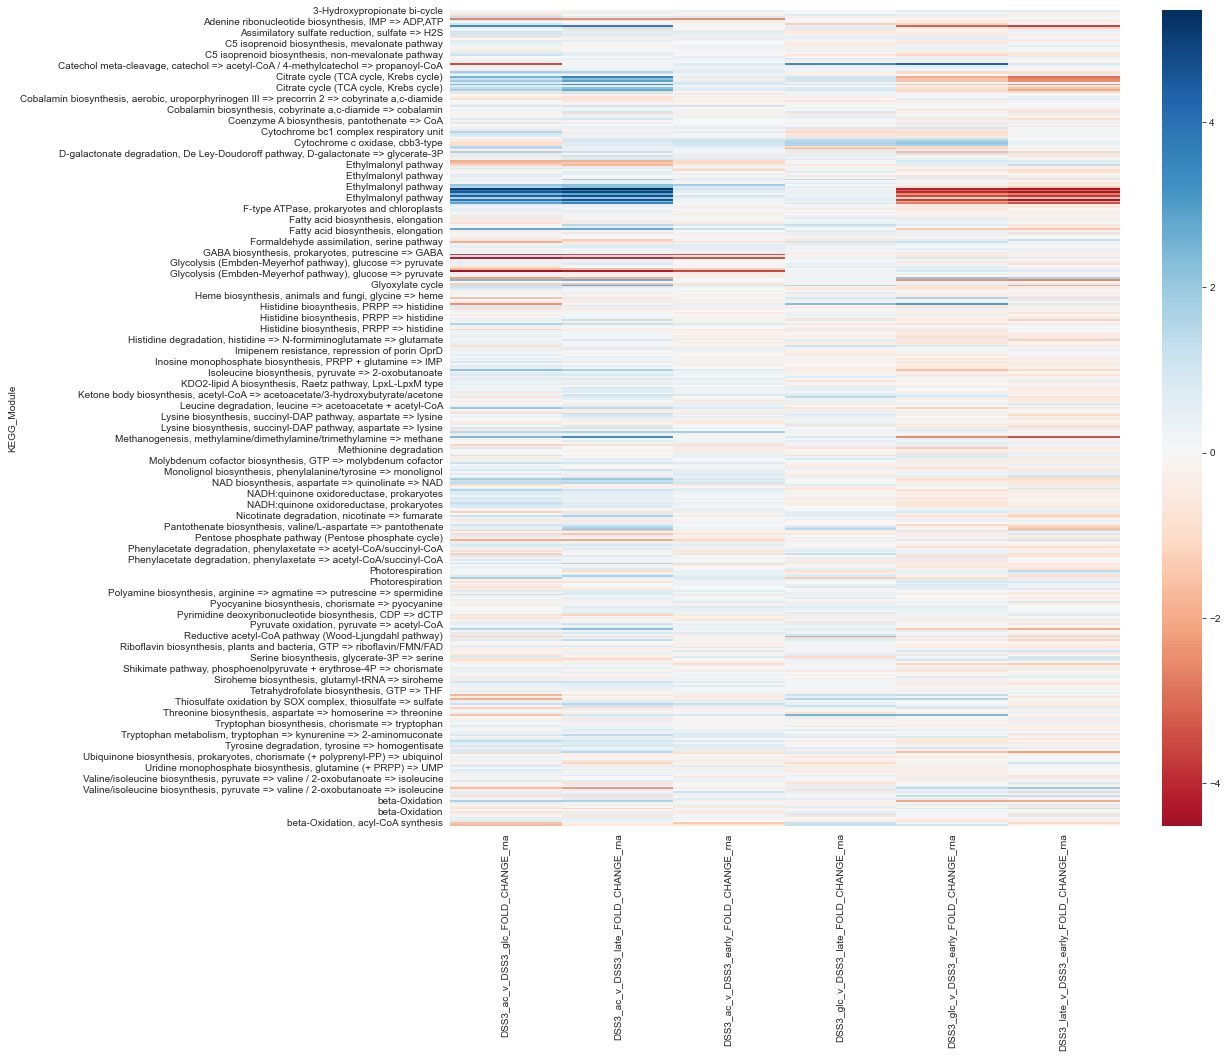

In [25]:
#Make a big plot of all FCs for DSS3 rna to look at broad patterns (See ethlymalonyl pathway!)
sns.set_style("white")
plt.figure(figsize=(15,15))
sns.heatmap(data=heat_sig_DSS3_rna_stats_genes_df,center=0,cmap='RdBu')

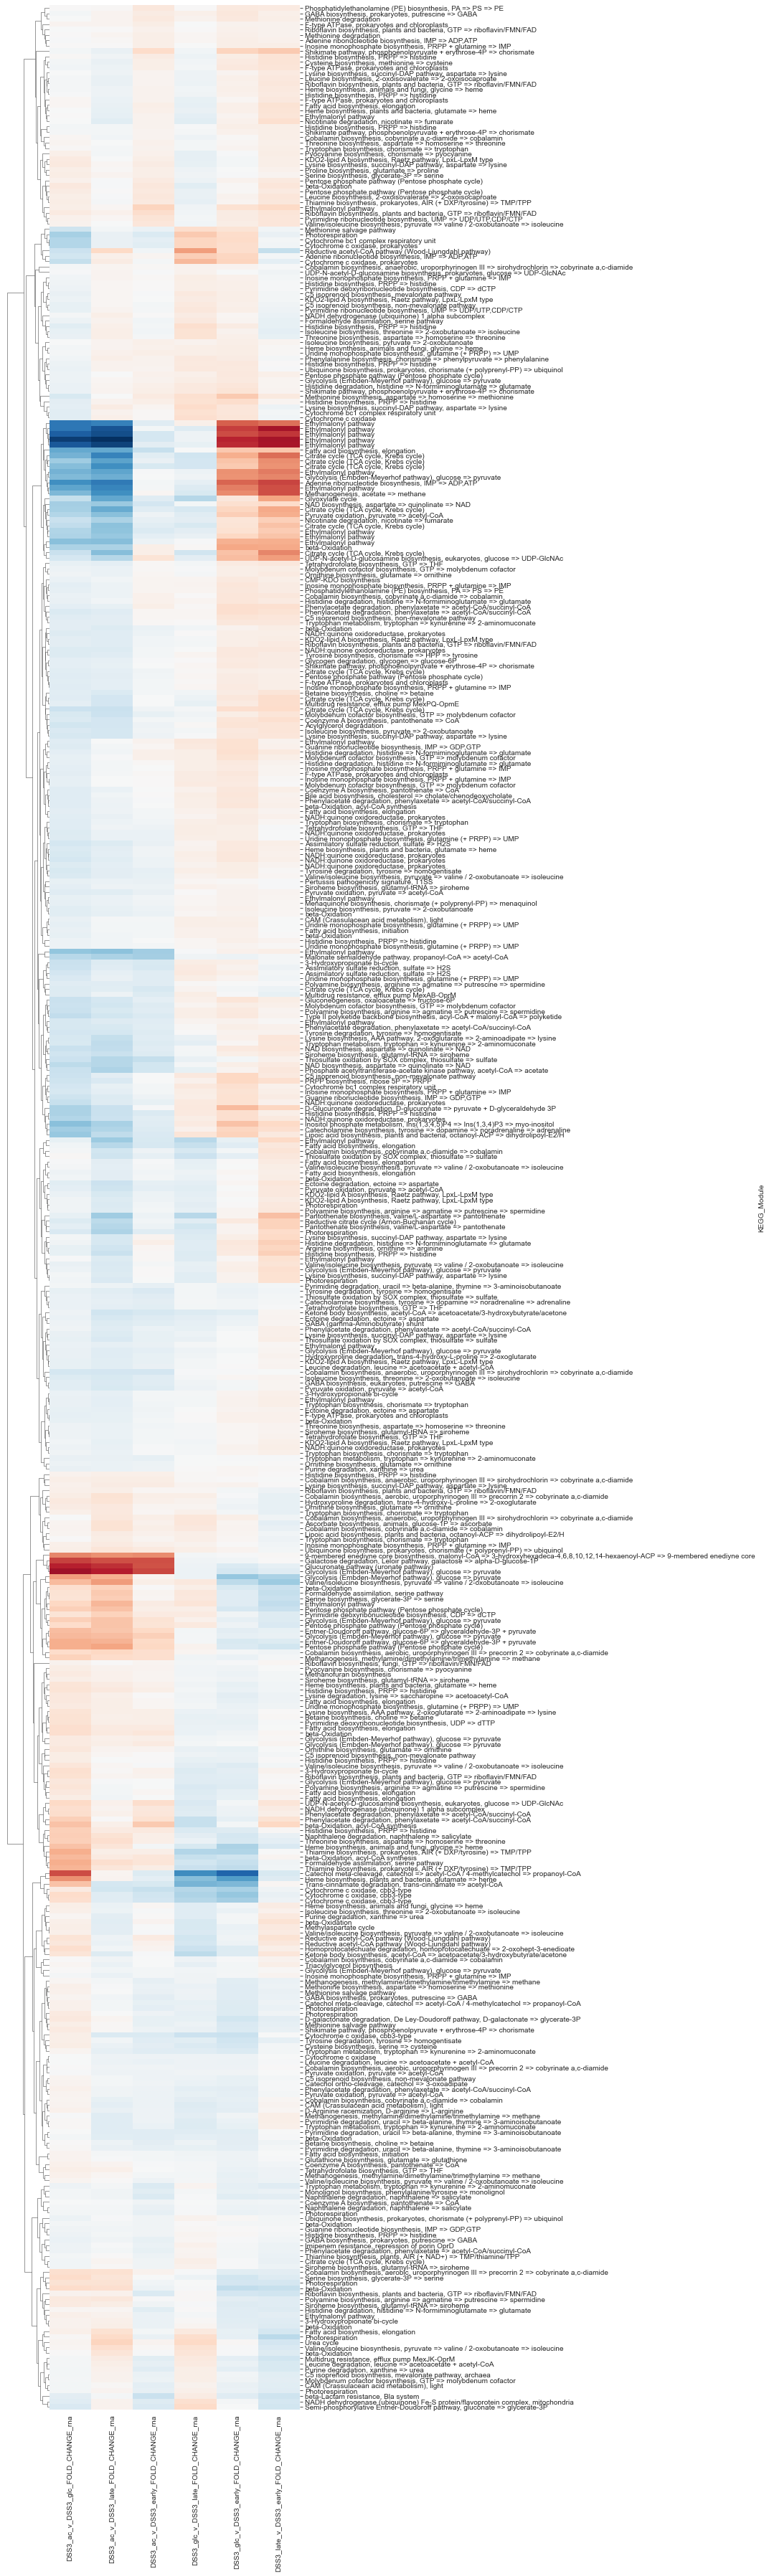

In [26]:
#Make it again as a clustermap to group together similar FC patterns
sns.clustermap(data=heat_sig_DSS3_rna_stats_genes_df,center=0,cmap='RdBu',figsize=(15,50),cbar_pos=None,col_cluster=False,yticklabels=True,dendrogram_ratio=(.15,0),metric='braycurtis')

In [27]:
#Repeat significance subsetting for MIT1002
sig_MIT1002_rna_stats_genes_df = MIT1002_rna_stats_genes_df[MIT1002_rna_stats_genes_df['BH_valid'] == True]

heat_sig_MIT1002_rna_stats_genes_df = sig_MIT1002_rna_stats_genes_df[['KEGG_Module','MIT1002_ac_v_MIT1002_glc_FOLD_CHANGE_rna', 'MIT1002_ac_v_MIT1002_late_FOLD_CHANGE_rna', 'MIT1002_ac_v_MIT1002_early_FOLD_CHANGE_rna', 
                                                                      'MIT1002_glc_v_MIT1002_late_FOLD_CHANGE_rna', 'MIT1002_glc_v_MIT1002_early_FOLD_CHANGE_rna', 'MIT1002_late_v_MIT1002_early_FOLD_CHANGE_rna',]]
heat_sig_MIT1002_rna_stats_genes_df = heat_sig_MIT1002_rna_stats_genes_df.set_index('KEGG_Module')
heat_sig_MIT1002_rna_stats_genes_df = heat_sig_MIT1002_rna_stats_genes_df.sort_index()
heat_sig_MIT1002_rna_stats_genes_df = heat_sig_MIT1002_rna_stats_genes_df[heat_sig_MIT1002_rna_stats_genes_df.index != 'nan']

In [28]:
#Check it again using Entner-Doudoroff as a check
sig_MIT1002_rna_stats_genes_df[sig_MIT1002_rna_stats_genes_df['KEGG_Module'].str.contains('entner',na=False,case=False)]

,Rank,gene_callers_id,MIT1002_ac_mean_abund,MIT1002_glc_mean_abund,MIT1002_late_mean_abund,MIT1002_early_mean_abund,MIT1002_ac_v_MIT1002_glc_FOLD_CHANGE_rna,MIT1002_ac_v_MIT1002_late_FOLD_CHANGE_rna,MIT1002_ac_v_MIT1002_early_FOLD_CHANGE_rna,MIT1002_glc_v_MIT1002_late_FOLD_CHANGE_rna,...,BH_valid,MIT1002_ac_v_MIT1002_glc_Tukey_HSD_adjusted_p,MIT1002_ac_v_MIT1002_late_Tukey_HSD_adjusted_p,MIT1002_ac_v_MIT1002_early_Tukey_HSD_adjusted_p,MIT1002_glc_v_MIT1002_late_Tukey_HSD_adjusted_p,MIT1002_glc_v_MIT1002_early_Tukey_HSD_adjusted_p,MIT1002_late_v_MIT1002_early_Tukey_HSD_adjusted_p,KOfam (ACCESSION),KEGG_Module,COG20_FUNCTION
37,38,2215,0.011877,0.081871,0.068065,0.048006,-2.775584,-2.519192,-2.012188,0.256392,...,True,0.0000,0.0001,0.004,NaN,NaN,NaN,K01625,"Entner-Doudoroff pathway, glucose-6P => glycer...",2-keto-3-deoxy-6-phosphogluconate aldolase (Ed...
164,165,2213,0.012410,0.093865,0.079477,0.048693,-2.888529,-2.677163,-1.962043,0.211366,...,True,0.0008,0.0027,NaN,NaN,NaN,NaN,K01690,"Entner-Doudoroff pathway, glucose-6P => glycer...",Dihydroxyacid dehydratase/phosphogluconate deh...


<AxesSubplot:ylabel='KEGG_Module'>

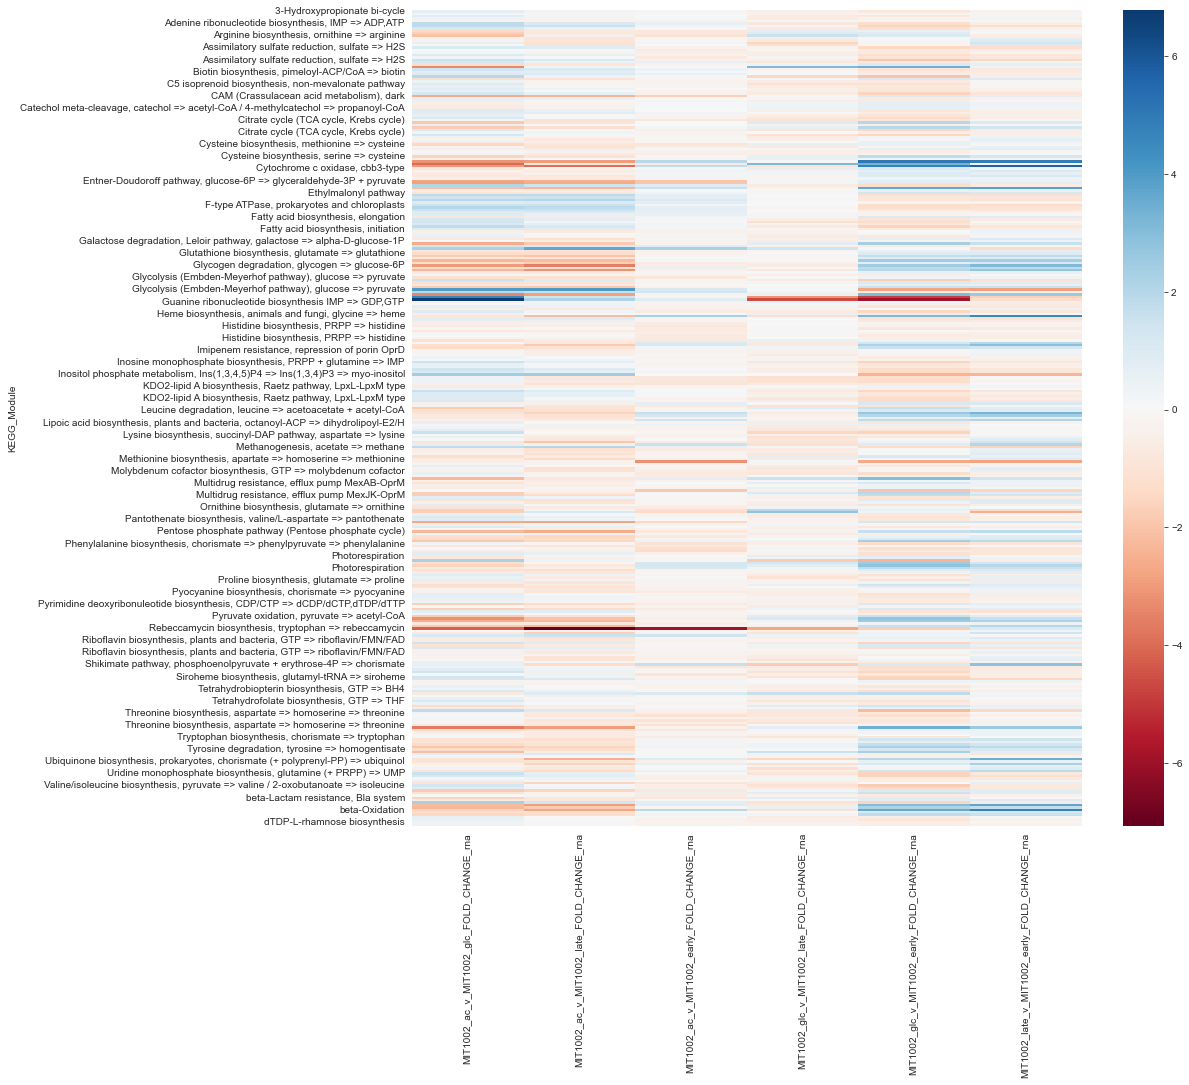

In [29]:
#Visualize the FCs
sns.set_style("white")
plt.figure(figsize=(15,15))
sns.heatmap(data=heat_sig_MIT1002_rna_stats_genes_df,center=0,cmap='RdBu')

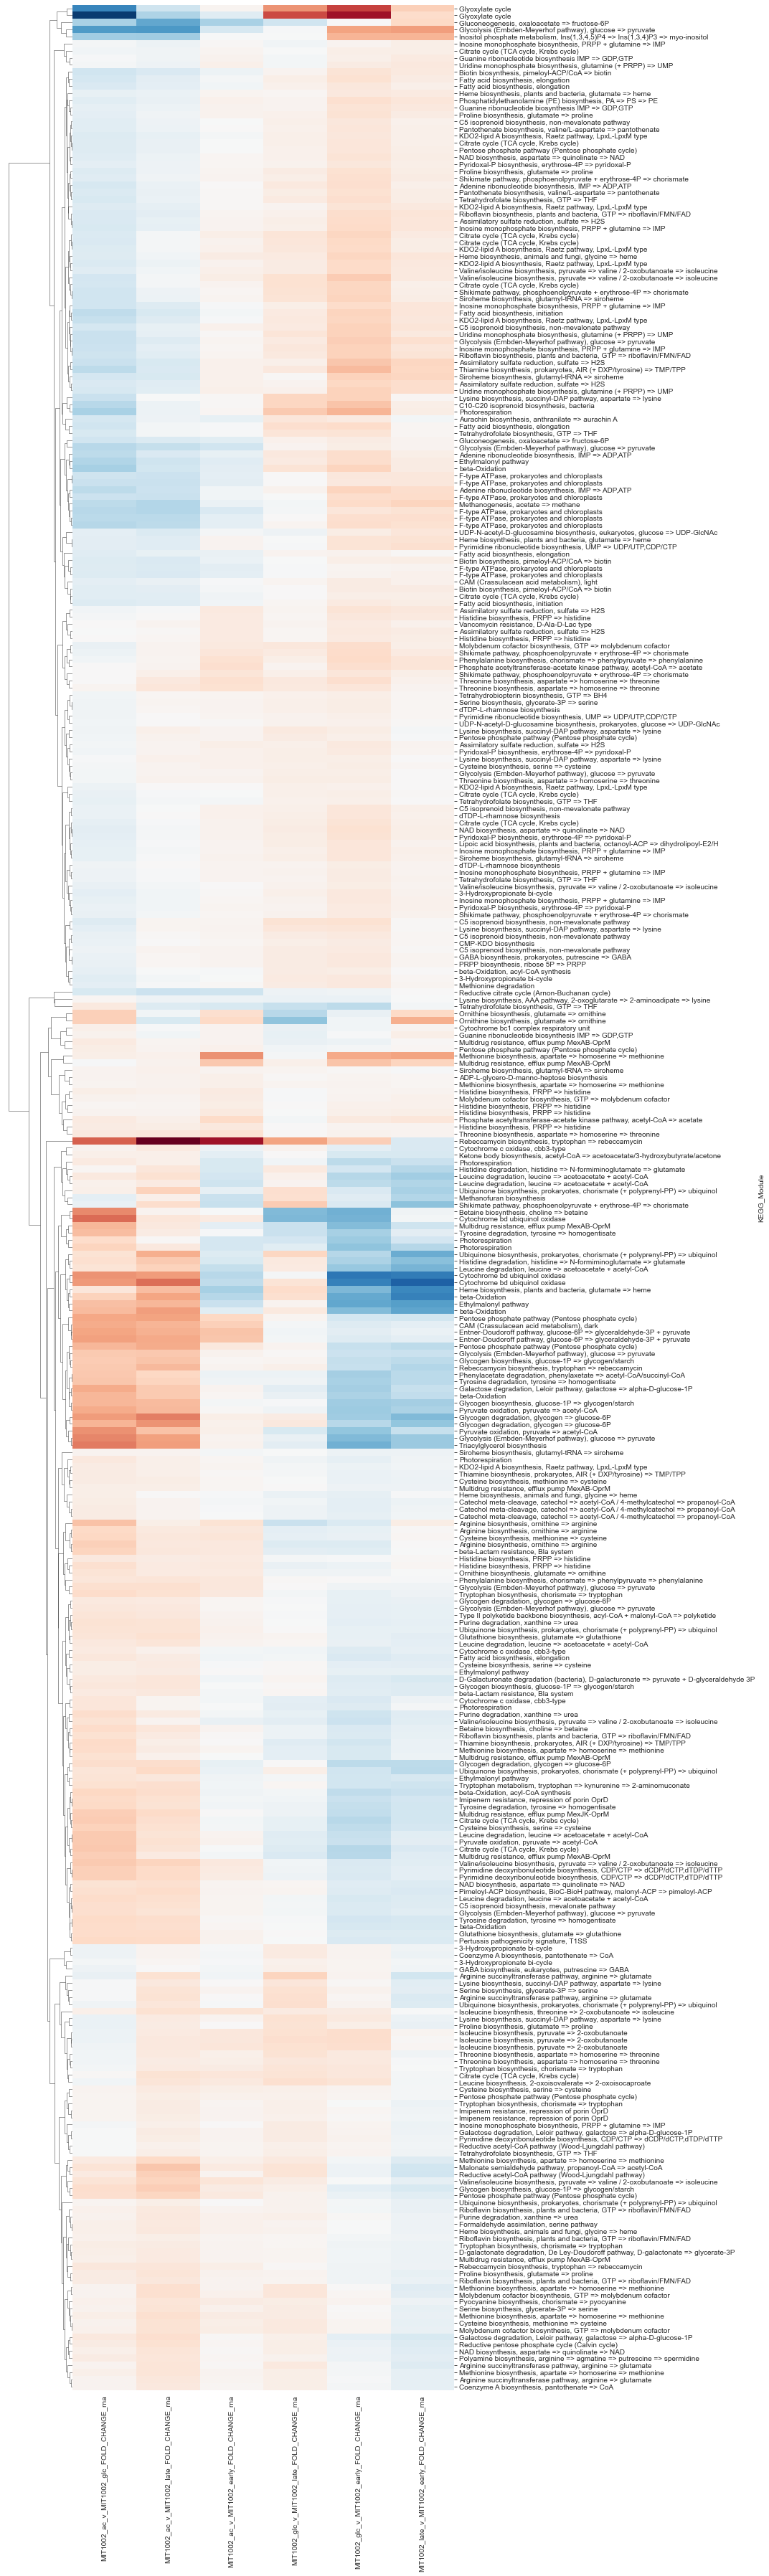

In [32]:
#Pull out similar FCs
sns.clustermap(data=heat_sig_MIT1002_rna_stats_genes_df,center=0,cmap='RdBu',figsize=(15,50),cbar_pos=None,col_cluster=False,yticklabels=True,dendrogram_ratio=(.15,0),metric='braycurtis')

In [39]:
#Need to make small heatmaps to get relevant data for ethylmalonyl pathway, TCA cycle, and glyoxylate shunt

#DSS-3 pathway specific dfs
DSS3_TCA_rna_stats_df = DSS3_rna_stats_genes_df[DSS3_rna_stats_genes_df['KEGG_Module'].str.contains('TCA',case=False)]
DSS3_TCA_prot_stats_df = DSS3_prot_stats_genes_df[DSS3_prot_stats_genes_df['KEGG_Module'].str.contains('TCA',case=False)]
DSS3_EMP_rna_stats_df = DSS3_rna_stats_genes_df[DSS3_rna_stats_genes_df['KEGG_Module'].str.contains('ethylmalonyl',case=False)]
DSS3_EMP_prot_stats_df = DSS3_prot_stats_genes_df[DSS3_prot_stats_genes_df['KEGG_Module'].str.contains('ethylmalonyl',case=False)]

#MIT1002 pathway specific dfs
MIT1002_TCA_rna_stats_df = MIT1002_rna_stats_genes_df[MIT1002_rna_stats_genes_df['KEGG_Module'].str.contains('TCA',case=False)]
MIT1002_TCA_prot_stats_df = MIT1002_prot_stats_genes_df[MIT1002_prot_stats_genes_df['KEGG_Module'].str.contains('TCA',case=False)]
MIT1002_GS_rna_stats_df = MIT1002_rna_stats_genes_df[MIT1002_rna_stats_genes_df['KEGG_Module'].str.contains('glyoxylate',case=False)]
MIT1002_GS_prot_stats_df = MIT1002_prot_stats_genes_df[MIT1002_prot_stats_genes_df['KEGG_Module'].str.contains('glyoxylate',case=False)]

In [40]:
#Let's only keep statistically significant data; a little redundant for the RNA dfs but its okay
DSS3_TCA_rna_stats_df = DSS3_TCA_rna_stats_df[DSS3_TCA_rna_stats_df['BH_valid'] == True]
DSS3_TCA_prot_stats_df = DSS3_TCA_prot_stats_df[DSS3_TCA_prot_stats_df['BH_valid'] == True]
DSS3_EMP_rna_stats_df = DSS3_EMP_rna_stats_df[DSS3_EMP_rna_stats_df['BH_valid'] == True]
DSS3_EMP_prot_stats_df = DSS3_EMP_prot_stats_df[DSS3_EMP_prot_stats_df['BH_valid'] == True]
MIT1002_TCA_rna_stats_df = MIT1002_TCA_rna_stats_df[MIT1002_TCA_rna_stats_df['BH_valid'] == True]
MIT1002_TCA_prot_stats_df = MIT1002_TCA_prot_stats_df[MIT1002_TCA_prot_stats_df['BH_valid'] == True]
MIT1002_GS_rna_stats_df = MIT1002_GS_rna_stats_df[MIT1002_GS_rna_stats_df['BH_valid'] == True]
MIT1002_GS_prot_stats_df = MIT1002_GS_prot_stats_df[MIT1002_GS_prot_stats_df['BH_valid'] == True]

In [41]:
#For all dfs, I am creating a column that I want to use as the index for the heatmap, makes interpretation a little.
DSS3_TCA_rna_stats_df['KM_KO'] = DSS3_TCA_rna_stats_df['KEGG_Module'] + DSS3_TCA_rna_stats_df['KOfam (ACCESSION)']
DSS3_TCA_prot_stats_df['KM_KO'] = DSS3_TCA_prot_stats_df['KEGG_Module'] + DSS3_TCA_prot_stats_df['KOfam (ACCESSION)']
DSS3_EMP_rna_stats_df['KM_KO'] = DSS3_EMP_rna_stats_df['KEGG_Module'] + DSS3_EMP_rna_stats_df['KOfam (ACCESSION)']
DSS3_EMP_prot_stats_df['KM_KO'] = DSS3_EMP_prot_stats_df['KEGG_Module'] + DSS3_EMP_prot_stats_df['KOfam (ACCESSION)']
MIT1002_TCA_rna_stats_df['KM_KO'] = MIT1002_TCA_rna_stats_df['KEGG_Module'] + MIT1002_TCA_rna_stats_df['KOfam (ACCESSION)']
MIT1002_TCA_prot_stats_df['KM_KO'] = MIT1002_TCA_prot_stats_df['KEGG_Module'] + MIT1002_TCA_prot_stats_df['KOfam (ACCESSION)']
MIT1002_GS_rna_stats_df['KM_KO'] = MIT1002_GS_rna_stats_df['KEGG_Module'] + MIT1002_GS_rna_stats_df['KOfam (ACCESSION)']
MIT1002_GS_prot_stats_df['KM_KO'] = MIT1002_GS_prot_stats_df['KEGG_Module'] + MIT1002_GS_prot_stats_df['KOfam (ACCESSION)']

#Now square them all up into heatmap shape
heat_DSS3_TCA_rna_stats_df = DSS3_TCA_rna_stats_df[['DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna','DSS3_late_v_DSS3_early_FOLD_CHANGE_rna','KM_KO']]
heat_DSS3_TCA_rna_stats_df.set_index('KM_KO',inplace=True)
heat_DSS3_TCA_prot_stats_df = DSS3_TCA_prot_stats_df[['DSS3_ac_v_DSS3_glc_FOLD_CHANGE_prot','DSS3_late_v_DSS3_early_FOLD_CHANGE_prot','KM_KO']]
heat_DSS3_TCA_prot_stats_df.set_index('KM_KO',inplace=True)
heat_DSS3_EMP_rna_stats_df = DSS3_EMP_rna_stats_df[['DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna','DSS3_late_v_DSS3_early_FOLD_CHANGE_rna','KM_KO']]
heat_DSS3_EMP_rna_stats_df.set_index('KM_KO',inplace=True)
heat_DSS3_EMP_prot_stats_df = DSS3_EMP_prot_stats_df[['DSS3_ac_v_DSS3_glc_FOLD_CHANGE_prot','DSS3_late_v_DSS3_early_FOLD_CHANGE_prot','KM_KO']]
heat_DSS3_EMP_prot_stats_df.set_index('KM_KO',inplace=True)
heat_MIT1002_TCA_rna_stats_df = MIT1002_TCA_rna_stats_df[['MIT1002_ac_v_MIT1002_glc_FOLD_CHANGE_rna','MIT1002_late_v_MIT1002_early_FOLD_CHANGE_rna','KM_KO']]
heat_MIT1002_TCA_rna_stats_df.set_index('KM_KO',inplace=True)
heat_MIT1002_TCA_prot_stats_df = MIT1002_TCA_prot_stats_df[['MIT1002_ac_v_MIT1002_glc_FOLD_CHANGE_prot','MIT1002_late_v_MIT1002_early_FOLD_CHANGE_prot','KM_KO']]
heat_MIT1002_TCA_prot_stats_df.set_index('KM_KO',inplace=True)
heat_MIT1002_GS_rna_stats_df = MIT1002_GS_rna_stats_df[['MIT1002_ac_v_MIT1002_glc_FOLD_CHANGE_rna','MIT1002_late_v_MIT1002_early_FOLD_CHANGE_rna','KM_KO']]
heat_MIT1002_GS_rna_stats_df.set_index('KM_KO',inplace=True)
heat_MIT1002_GS_prot_stats_df = MIT1002_GS_prot_stats_df[['MIT1002_ac_v_MIT1002_glc_FOLD_CHANGE_prot','MIT1002_late_v_MIT1002_early_FOLD_CHANGE_prot','KM_KO']]
heat_MIT1002_GS_prot_stats_df.set_index('KM_KO',inplace=True)

In [42]:
#Do a quick data manipulation to make acetate and early conditions the same color for DSS-3 (since DSS3 draws down acetate before glucose)
#Also change column label to match the manipulation
heat_DSS3_TCA_rna_stats_df['DSS3_early_v_DSS3_late_FOLD_CHANGE_rna'] = heat_DSS3_TCA_rna_stats_df['DSS3_late_v_DSS3_early_FOLD_CHANGE_rna'] * -1
heat_DSS3_TCA_rna_stats_df.drop(labels=['DSS3_late_v_DSS3_early_FOLD_CHANGE_rna'],axis=1,inplace=True)
heat_DSS3_TCA_prot_stats_df['DSS3_early_v_DSS3_late_FOLD_CHANGE_prot'] = heat_DSS3_TCA_prot_stats_df['DSS3_late_v_DSS3_early_FOLD_CHANGE_prot'] * -1
heat_DSS3_TCA_prot_stats_df.drop(labels=['DSS3_late_v_DSS3_early_FOLD_CHANGE_prot'],axis=1,inplace=True)

heat_DSS3_EMP_rna_stats_df['DSS3_early_v_DSS3_late_FOLD_CHANGE_rna'] = heat_DSS3_EMP_rna_stats_df['DSS3_late_v_DSS3_early_FOLD_CHANGE_rna'] * -1
heat_DSS3_EMP_rna_stats_df.drop(labels=['DSS3_late_v_DSS3_early_FOLD_CHANGE_rna'],axis=1,inplace=True)
heat_DSS3_EMP_prot_stats_df['DSS3_early_v_DSS3_late_FOLD_CHANGE_prot'] = heat_DSS3_EMP_prot_stats_df['DSS3_late_v_DSS3_early_FOLD_CHANGE_prot'] * -1
heat_DSS3_EMP_prot_stats_df.drop(labels=['DSS3_late_v_DSS3_early_FOLD_CHANGE_prot'],axis=1,inplace=True)

#MIT1002 works as is where glucose and early are the same end of the spectrum, matching preferences

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [45]:
#We also want to check our pairwise p-values for validation
p_cols = [col for col in DSS3_TCA_rna_stats_df.columns if "adjusted" in col]
p_cols.insert(0,'KM_KO')
DSS3_TCA_rna_stats_df[p_cols]

,KM_KO,DSS3_ac_v_DSS3_glc_Tukey_HSD_adjusted_p,DSS3_ac_v_DSS3_late_Tukey_HSD_adjusted_p,DSS3_ac_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_glc_v_DSS3_late_Tukey_HSD_adjusted_p,DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p
27,"Citrate cycle (TCA cycle, Krebs cycle)K00658",0.0000,0.0000,0.0000,0.0046,NaN,NaN
40,"Citrate cycle (TCA cycle, Krebs cycle)K01902",0.0000,0.0000,0.0001,NaN,NaN,NaN
50,"Citrate cycle (TCA cycle, Krebs cycle)K01903",0.0001,0.0000,0.0088,0.0108,NaN,NaN
66,"Citrate cycle (TCA cycle, Krebs cycle)K01681",0.0000,0.0000,0.0001,0.0013,NaN,NaN
75,"Citrate cycle (TCA cycle, Krebs cycle)K00164",0.0000,0.0000,0.0002,0.0239,NaN,NaN
141,"Citrate cycle (TCA cycle, Krebs cycle)K01647",0.0000,0.0000,0.0000,0.0010,NaN,NaN
314,"Citrate cycle (TCA cycle, Krebs cycle)K00239",0.0000,0.0000,NaN,NaN,NaN,NaN
1240,"Citrate cycle (TCA cycle, Krebs cycle)K01679",0.0003,0.0010,0.0001,NaN,NaN,NaN
1522,"Citrate cycle (TCA cycle, Krebs cycle)K00240",0.0203,0.0036,NaN,NaN,NaN,NaN
1545,"Citrate cycle (TCA cycle, Krebs cycle)K01676",NaN,NaN,0.0478,0.0033,NaN,NaN


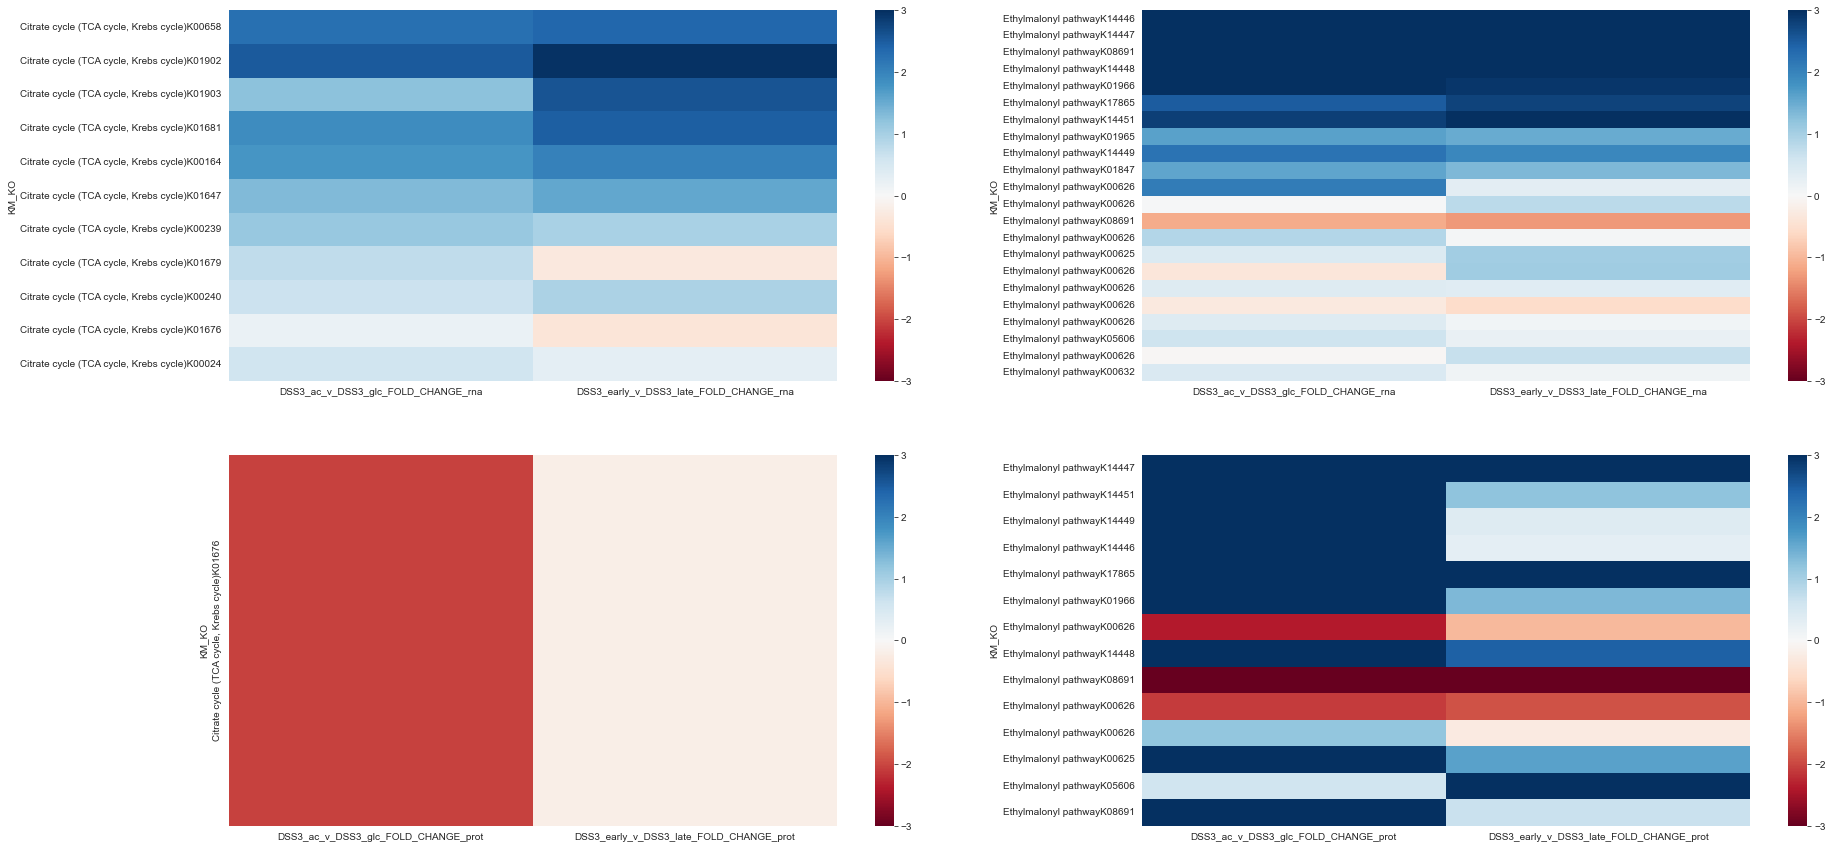

In [46]:
#Now, let's make a couple of summary heatmaps
#These are used to color in the metabolic pathway figure. 
#Where there are multiple copies of a gene (by KO), I used the first from the top as it has the higher significance by BH ranking
fig,axs = plt.subplots(2,2,figsize=(30,15))

h1 = sns.heatmap(data=heat_DSS3_TCA_rna_stats_df,ax=axs[0,0],cmap='RdBu',center=0,vmax=3,vmin=-3)
h2 = sns.heatmap(data=heat_DSS3_TCA_prot_stats_df,ax=axs[1,0],cmap='RdBu',center=0,vmax=3,vmin=-3)
h3 = sns.heatmap(data=heat_DSS3_EMP_rna_stats_df,ax=axs[0,1],cmap='RdBu',center=0,vmax=3,vmin=-3)
h4 = sns.heatmap(data=heat_DSS3_EMP_prot_stats_df,ax=axs[1,1],cmap='RdBu',center=0,vmax=3,vmin=-3)

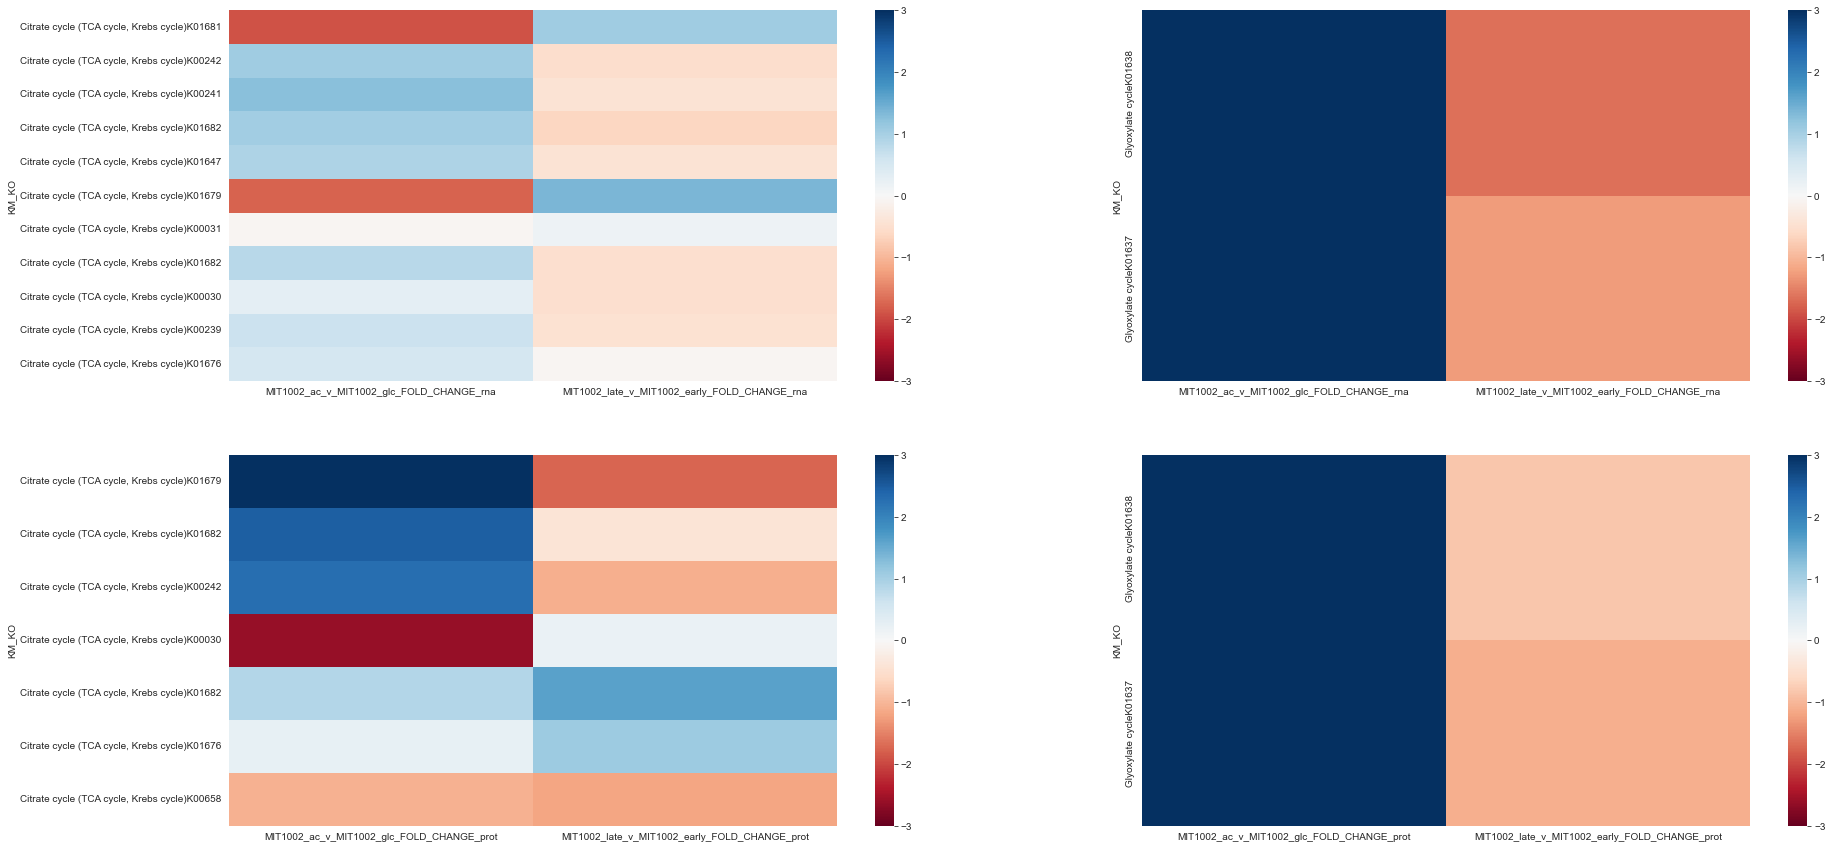

In [63]:
#Now, let's make a couple of summary heatmaps for MIT1002
fig2,axs2 = plt.subplots(2,2,figsize=(30,15))

h5 = sns.heatmap(data=heat_MIT1002_TCA_rna_stats_df,ax=axs2[0,0],cmap='RdBu',center=0,vmax=3,vmin=-3)
h6 = sns.heatmap(data=heat_MIT1002_TCA_prot_stats_df,ax=axs2[1,0],cmap='RdBu',center=0,vmax=3,vmin=-3)
h7 = sns.heatmap(data=heat_MIT1002_GS_rna_stats_df,ax=axs2[0,1],cmap='RdBu',center=0,vmax=3,vmin=-3)
h8 = sns.heatmap(data=heat_MIT1002_GS_prot_stats_df,ax=axs2[1,1],cmap='RdBu',center=0,vmax=3,vmin=-3)

In [56]:
#Check protein abundances to set minimum cutoff
print(DSS3_prot_stats_df[['DSS3_ac_mean_abund','DSS3_glc_mean_abund','DSS3_late_mean_abund','DSS3_early_mean_abund']].quantile(q=0.05))
print(MIT1002_prot_stats_df[['MIT1002_ac_mean_abund','MIT1002_glc_mean_abund','MIT1002_late_mean_abund','MIT1002_early_mean_abund']].quantile(q=0.05))

DSS3_ac_mean_abund       0.000002
DSS3_glc_mean_abund      0.000004
DSS3_late_mean_abund     0.000003
DSS3_early_mean_abund    0.000002
Name: 0.05, dtype: float64
MIT1002_ac_mean_abund       0.000003
MIT1002_glc_mean_abund      0.000003
MIT1002_late_mean_abund     0.000003
MIT1002_early_mean_abund    0.000003
Name: 0.05, dtype: float64


In [59]:
#5% of prots for each sample are below 0.000003 ± 0.000001, 95% are above. Seems like a good cutoff to weed out very low abundance proteins (possible false positives)

#Check prot abundances for annotating metabolic pathway map
DSS3_TCA_prot_stats_df[['KM_KO','DSS3_ac_mean_abund','DSS3_glc_mean_abund']] #only one TCA enzyme shows up in the proteome

,KM_KO,DSS3_ac_mean_abund,DSS3_glc_mean_abund
238,"Citrate cycle (TCA cycle, Krebs cycle)K01676",0.001942,0.007512


In [58]:
DSS3_EMP_prot_stats_df[['KM_KO','DSS3_ac_mean_abund','DSS3_glc_mean_abund']]

,KM_KO,DSS3_ac_mean_abund,DSS3_glc_mean_abund
15,Ethylmalonyl pathwayK14447,0.006931,0.000120
23,Ethylmalonyl pathwayK14451,0.008855,0.000315
34,Ethylmalonyl pathwayK14449,0.004291,0.000480
69,Ethylmalonyl pathwayK14446,0.036514,0.001455
80,Ethylmalonyl pathwayK17865,0.000524,0.000012
86,Ethylmalonyl pathwayK01966,0.004687,0.000195
98,Ethylmalonyl pathwayK00626,0.000335,0.001773
133,Ethylmalonyl pathwayK14448,0.010669,0.000843
169,Ethylmalonyl pathwayK08691,0.000014,0.000104
203,Ethylmalonyl pathwayK00626,0.001455,0.005402


In [60]:
MIT1002_TCA_prot_stats_df[['KM_KO','MIT1002_ac_mean_abund','MIT1002_glc_mean_abund']]

,KM_KO,MIT1002_ac_mean_abund,MIT1002_glc_mean_abund
34,"Citrate cycle (TCA cycle, Krebs cycle)K01679",0.000161,0.000008
71,"Citrate cycle (TCA cycle, Krebs cycle)K01682",0.025217,0.004507
93,"Citrate cycle (TCA cycle, Krebs cycle)K00242",0.001963,0.000423
185,"Citrate cycle (TCA cycle, Krebs cycle)K00030",0.000492,0.002695
208,"Citrate cycle (TCA cycle, Krebs cycle)K01682",0.039613,0.021141
214,"Citrate cycle (TCA cycle, Krebs cycle)K01676",0.010293,0.008657
345,"Citrate cycle (TCA cycle, Krebs cycle)K00658",0.013466,0.027940


In [61]:
MIT1002_GS_prot_stats_df[['KM_KO','MIT1002_ac_mean_abund','MIT1002_glc_mean_abund']]

,KM_KO,MIT1002_ac_mean_abund,MIT1002_glc_mean_abund
14,Glyoxylate cycleK01638,0.025168,0.000032
22,Glyoxylate cycleK01637,0.220298,0.000118


#### This completes the statistical processing and data gathering of transcriptomics and proteomics for this experiment.